<img src="images/DeepLearning.jpg" align="center" style="height: 400px;"/>
$\hspace{230pt} \text{Deep Learning}$


# Занятие №4

## План на сегодня

1. Еще раз о работе с изображениями, подробнее о CNN. Stride и padding.
2. Слои свертки и пулинга.
3. Популярные архитектуры CNN.
4. Реализация CNN.
5. Проверочная работа.

# 1. Сверточные нейронные сети (CNN)

Хорошая статья: [Как работает сверточная нейронная сеть: архитектура, примеры, особенности](https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/)

## Polling слои:
<img src="images/pool.png" align="center" style="height: 400px;"/> 

<img src="images/av_pool.png" align="center" style="height: 400px;"/>

# 2. Популярные архитектуры CNN:
- LeNet (1994 год)
- AlexNet (2012 год)
- VGGNet (2014 год)
- GoogLeNet, Inception (2014 год)
- ResNet (2015 год)
- DenseNet (2018 год)
- AmoebaNet (2019 год)
- EfficientNet (2019 год)

<img src="images/LeNet.jpg" align="center" style="height: 400px;"/> 

Нет padding, stride = 1.

# 3. Реализация CNN

In [3]:
import keras
import sys
import zipfile # для работы с архивами 
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from matplotlib.pyplot import imread
from PIL import Image
from tensorflow.keras.preprocessing import image as im
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
train_path = "train/"
test_path = "test/"

In [5]:
class_names = os.listdir(train_path)
print(len(class_names))

9


In [8]:
img_width, img_height = 50, 50
nb_train_samples = 1458
nb_validation_samples = 158
epochs = 50
batch_size = 8
n_classes = 9

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    rotation_range = 5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = False,
    vertical_flip = False)

In [10]:
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [11]:
def build_model_DenseNet():
    base_model = densenet.DenseNet121(include_top=True, 
                                      weights = None,
                                      input_tensor = None,
                                      input_shape = (img_width, img_height, 3),
                                      pooling = None,
                                      classes = n_classes)
    
    for layer in base_model.layers:
        layer.trainable = True

    model = Model(inputs = base_model.input, outputs = base_model.output)
    return model

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 1458 images belonging to 9 classes.
Found 158 images belonging to 9 classes.


In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose=1, min_delta = 1e-4) 
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)

callbacks_list = [early_stop, reduce_lr]

In [15]:
model = build_model_DenseNet()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

In [28]:
# Загрузка модели
loaded_model = load_model("Best_DenseNet121_50_epochs.hdf5")

# Описание о модели
print(loaded_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 25, 25, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalizationV1) (None, 25, 25, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

<class 'PIL.Image.Image'>
(50, 50)


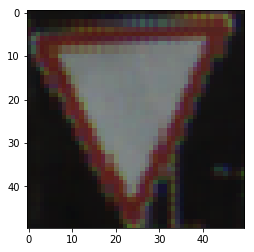

(1, 50, 50, 3)
<class 'numpy.ndarray'>
float32
2


In [29]:
img_path = "test/2/2019-01-31-15-49-59_kia_velo_gps_time_stereo_leftimg_000680.png"

img = im.load_img(img_path, target_size = (img_width, img_height))
print(type(img))
print(img.size)

plt.imshow(img)
plt.show()

x = im.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

print(x.shape)
print(type(x))
print(x.dtype)

ans = np.argmax(loaded_model.predict(x))
print(ans)

In [30]:
start_time = time.time()
print("Predicted class is", np.argmax(model.predict(x)))
print("Time to predict an image is", (time.time() - start_time), "seconds")

Predicted class is 8
Time to predict an image is 0.07277154922485352 seconds


In [31]:
# Проверка качества сети (accuracy)

right = 0
wrong = 0
times = []

for folder in os.listdir("test"):
    for img in os.listdir("test/" + folder):
        imag = im.load_img("test/" + folder + "/" + img, target_size = (img_width, img_height))
        
        photo_ar = im.img_to_array(imag)
        photo_ar = np.expand_dims(photo_ar, axis = 0)
        photo_ar /= 255
        
        start_time = time.time()
        ans = np.argmax(loaded_model.predict(photo_ar))
        times.append(time.time() - start_time)
        
        if ans == int(folder):
            right += 1
        else:
            wrong += 1

In [32]:
print("Accuracy on validation set is", right/(right + wrong))
print("Average time to pridict one photo is", np.array(times).mean(), "seconds")

Accuracy on validation set is 0.8037974683544303
Average time to pridict one photo is 0.059356612495229215 seconds


In [33]:
# Проверка качества сети по классам (Precision and Recall)

TP = [i - i for i in range(len(class_names))]
FN = [i - i for i in range(len(class_names))]
FP = [i - i for i in range(len(class_names))]

precision = [i - i for i in range(len(class_names))]
recall = [i - i for i in range(len(class_names))]

for folder in os.listdir("test"):
    for img in os.listdir("test/" + folder):
        imag = im.load_img("test/" + folder + "/" + img, target_size = (img_width, img_height))
        
        photo_ar = im.img_to_array(imag)
        photo_ar = np.expand_dims(photo_ar, axis = 0)
        photo_ar /= 255
        
        ans = np.argmax(loaded_model.predict(photo_ar))
    
        if ans == int(folder):
            TP[ans] += 1
        if ans != int(folder):
            FN[ans] += 1
            FP[int(folder)] += 1

In [34]:
for i in range(len(class_names)):
    precision[i] = TP[i]/(TP[i] + FP[i])
    recall[i] = TP[i]/(TP[i] + FN[i]) 
    
precision = np.array(precision)
recall = np.array(recall)

print(precision.max(), precision.min(), precision.mean())
print(recall.max(), recall.min(), recall.mean())

1.0 0.42857142857142855 0.816420954346651
1.0 0.6086956521739131 0.8373214547127592


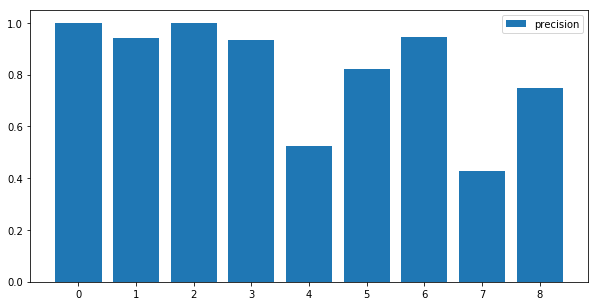

In [35]:
# Визуализируем 

Fload = [i for i in range(9)]

plt.figure(figsize = (10,5))
x = range(len(precision))
ax = plt.gca()
ax.bar(Fload, precision, label = "precision")
ax.set_xticks(x)
plt.legend(loc = 'best')
plt.show()

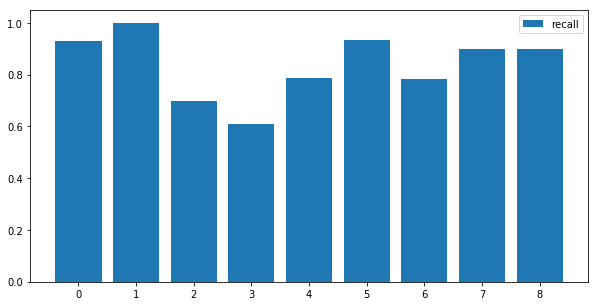

In [36]:
plt.figure(figsize = (10,5))
ax = plt.gca()
ax.bar(Fload, recall, label = "recall")
plt.legend(loc='best')
ax.set_xticks(x)
ax.set_xticks(x)
plt.show()

Другие встроенные архитетктуры: https://keras.io/applications/

<img src="images/myself.jpg" align="center" style="height: 400px;"/> 

# 4. Что мы умеем (должны уметь):
- Обрабатывать и анализировать данные
- Знать pandas, matplotlib и seaborn
- Понимать что такое FCN и CNN
- Уметь определить класс задачи, выбрать подходящую архитектуру нейронной сети, функцию потерь и метрики качетсва
- Уметь создавать, обучать и валидировать модели
- Уметь улучшать модели, знать проблемы нейронных сетей
- Знать keras и pytorch
- Уметь применять уже готовые модели